# Survival Prediction Model

## Step 1: Load Required Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from sksurv.ensemble import RandomSurvivalForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sksurv.metrics import concordance_index_censored

## Step 2: Load and Preprocess the Data

In [3]:
# Load dataset (modify file name accordingly)
df = pd.read_csv("C:/Users/HP/Desktop/Thesis/ML1.csv")

# Check dataset structure
print(df.head())

# Convert survival data to lifelines/sklearn-survival format
df["Survival_Status"] = df["Survival_Status"].astype(int)  # Ensure event is integer (1/0)
df["Survival_Time"] = df["Survival_Time"].astype(float)  # Ensure time is float


   Survival_Time  Survival_Status  LINC01614  FRMD6-AS2  PGM5-AS1  HOXC-AS1  \
0           1431                0         24          0         6         4   
1            439                1        297          7       108        15   
2           1645                0         19          3         5        28   
3           1043                1        109          2         0        26   
4            273                0          1          0        22         0   

   LINC01050  LINC01634  FEZF1-AS1  LINC02668  HOTAIR  
0          9          2         15          1      25  
1        105          0        329          0      21  
2         70          6         60          6     223  
3         36          0       1517          1      38  
4          0          2          0         39       0  


## Step 3: Kaplan-Meier Survival Analysis

P-values for all genes:
LINC01614: 0.0042
FRMD6-AS2: 0.0080
PGM5-AS1: 0.0123
HOXC-AS1: 0.4414
LINC01050: 0.0811
LINC01634: 0.1951
FEZF1-AS1: 0.6897
LINC02668: 0.4175
HOTAIR: 0.6226
group: 0.6226


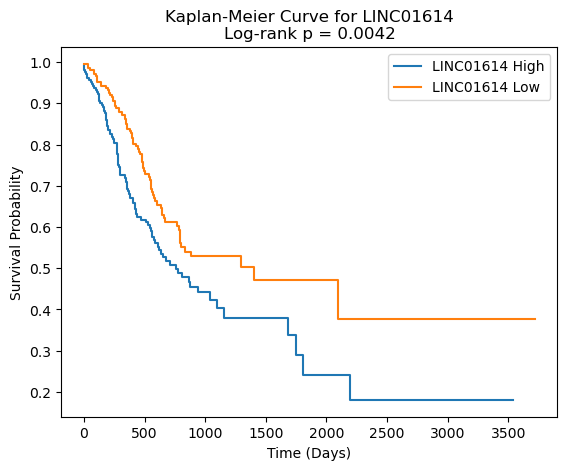

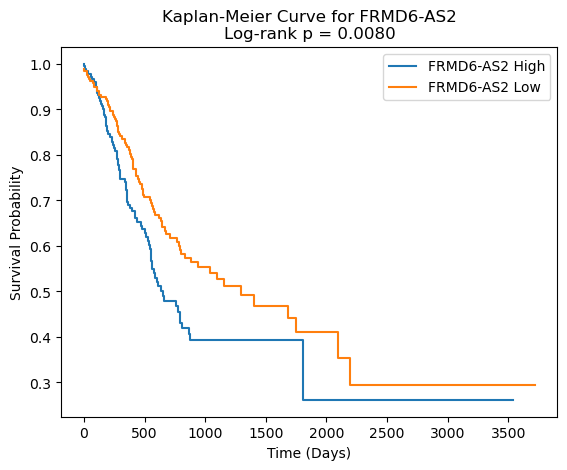

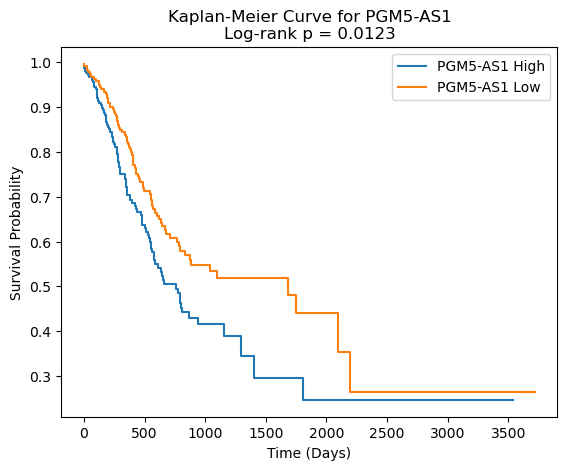

In [6]:
kmf = KaplanMeierFitter()
gene_pvalues = {}

# Step 1: Calculate and store p-values for all genes
for gene in df.columns[2:]:  # Assuming columns: Time, Status, then genes
    median_expr = df[gene].median()
    df["group"] = df[gene] > median_expr

    # Log-rank test
    results = logrank_test(df["Survival_Time"][df["group"]], df["Survival_Time"][~df["group"]],
                           event_observed_A=df["Survival_Status"][df["group"]],
                           event_observed_B=df["Survival_Status"][~df["group"]])
    gene_pvalues[gene] = results.p_value

# Step 2: Print p-values for all genes
print("P-values for all genes:")
for gene, pval in gene_pvalues.items():
    print(f"{gene}: {pval:.4f}")

# Step 3: Plot only significant ones (p < 0.05)
for gene, pval in gene_pvalues.items():
    if pval < 0.05:
        median_expr = df[gene].median()
        df["group"] = df[gene] > median_expr

        kmf.fit(df["Survival_Time"][df["group"]], event_observed=df["Survival_Status"][df["group"]], label=f"{gene} High")
        ax = kmf.plot(ci_show=False)

        kmf.fit(df["Survival_Time"][~df["group"]], event_observed=df["Survival_Status"][~df["group"]], label=f"{gene} Low")
        kmf.plot(ax=ax, ci_show=False)

        plt.title(f"Kaplan-Meier Curve for {gene}\nLog-rank p = {pval:.4f}")
        plt.xlabel("Time (Days)")
        plt.ylabel("Survival Probability")
        plt.legend()
        plt.show()
